In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import talib
import seaborn as sns
import matplotlib.pyplot as plt
import backtesting as bt
from numpy import sqrt

/Users/metomatt/Documents/vscode/.venv/lib/python3.13/site-packages/backtesting/_plotting.py:55: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support, such as old IDEs. Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [2]:
window = 7

btc = yf.download('BTC-USD', start='2022-01-01', end='2026-01-01', interval='1d')
btc = btc.dropna()

[*********************100%***********************]  1 of 1 completed

YF.download() has changed argument auto_adjust default to True


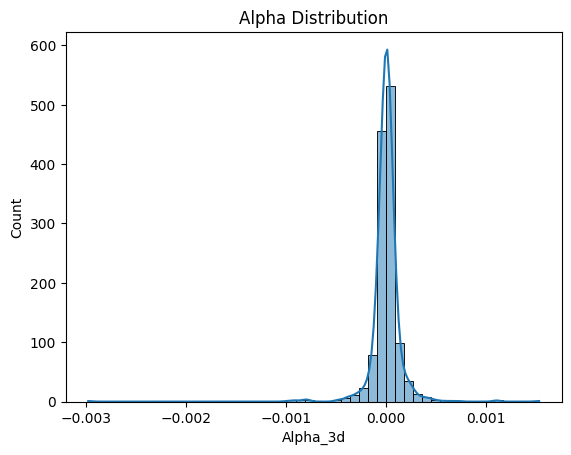

In [3]:
btc['Return'] = btc['Close'] / btc['Close'].shift(1) - 1 

btc['Return_7d'] = btc['Close'] / btc['Close'].shift(window) - 1
btc['Volatility_7d'] = btc['Close'].rolling(window).std()         #Volatility in 7 days  
btc['Alpha_7d'] = btc['Return_7d'] / btc['Volatility_7d']   

btc['Return_3d'] = btc['Close'] / btc['Close'].shift(3) - 1
btc['Volatility_3d'] = btc['Close'].rolling(3).std()       #Alpha = Return / Volatility
btc['Alpha_3d'] = btc['Return_3d'] / btc['Volatility_3d']
    

sns.histplot(btc['Alpha_3d'].dropna(), bins=50, kde=True)
plt.title('Alpha Distribution')
plt.show()

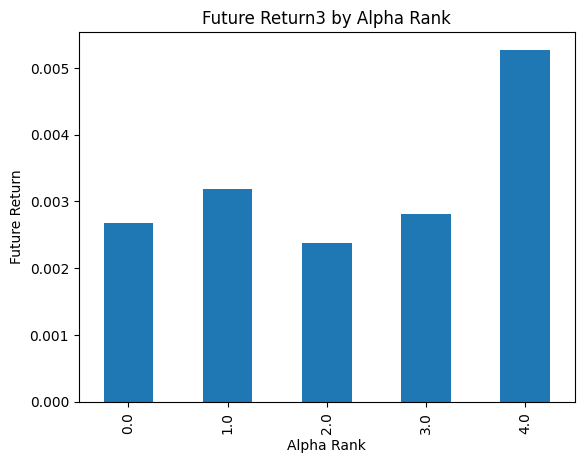

In [4]:
btc['AlphaRank'] = pd.qcut(btc['Alpha_3d'], 5, labels=False) # 5 groups of Alpha
btc['Future_Return'] = btc['Close'].shift(-3) / btc['Close'] - 1
btc.groupby('AlphaRank')['Future_Return'].mean().plot(kind='bar')
plt.title('Future Return3 by Alpha Rank')
plt.xlabel('Alpha Rank')
plt.ylabel('Future Return')
plt.show()

<Axes: title={'center': 'Strategy vs Market'}, xlabel='Date'>

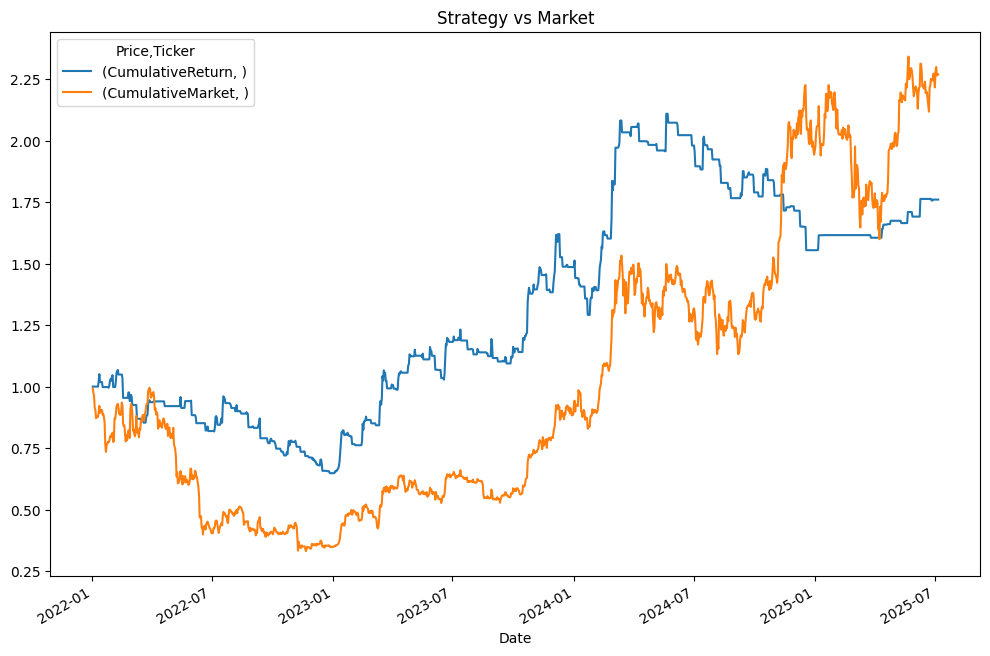

In [9]:
btc['Signal'] = 0
btc.loc[btc['Alpha_3d'] > btc['Alpha_3d'].quantile(0.7), 'Signal'] = 1   
btc['Position'] = btc['Signal'].shift(1).fillna(0)   
btc['StrategyReturn'] = btc['Position'] * btc['Return']
btc['CumulativeReturn'] = (1 + btc['StrategyReturn']).cumprod()
btc['CumulativeMarket'] = (1 + btc['Return']).cumprod()

btc[['CumulativeReturn', 'CumulativeMarket']].plot(figsize=(12, 8), title='Strategy vs Market')

In [28]:
def sharpe(r):
    return r.mean() / r.std() * sqrt(252)

def max_drawdown(cum_returns):
    peak = cum_returns.cummax()
    drawdown = cum_returns / peak - 1
    return drawdown.min()


print("Win Rate: ", (btc["StrategyReturn"] > 0).mean())   # not win rate / lose rate?
print("Annual Return: ", btc["StrategyReturn"].mean() * 252)
print("Sharpe Ratio: ", sharpe(btc["StrategyReturn"]))
print("Max Drawdown: ", max_drawdown(btc["CumulativeReturn"]))

Win Rate:  0.1372854914196568
Annual Return:  0.1370856690717099
Sharpe Ratio:  0.5994174455269395
Max Drawdown:  -0.39331392299014256
